<a href="https://colab.research.google.com/github/lituldust/Machine-Learning-Study/blob/Projects/Covid_19_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


In [2]:
train_path = '/root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train'
test_path = '/root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/test'

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os

def get_image_paths_and_labels(path):
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Folder name is the label
    return image_paths, labels

# Get all image paths and labels
image_paths, labels = get_image_paths_and_labels(train_path)

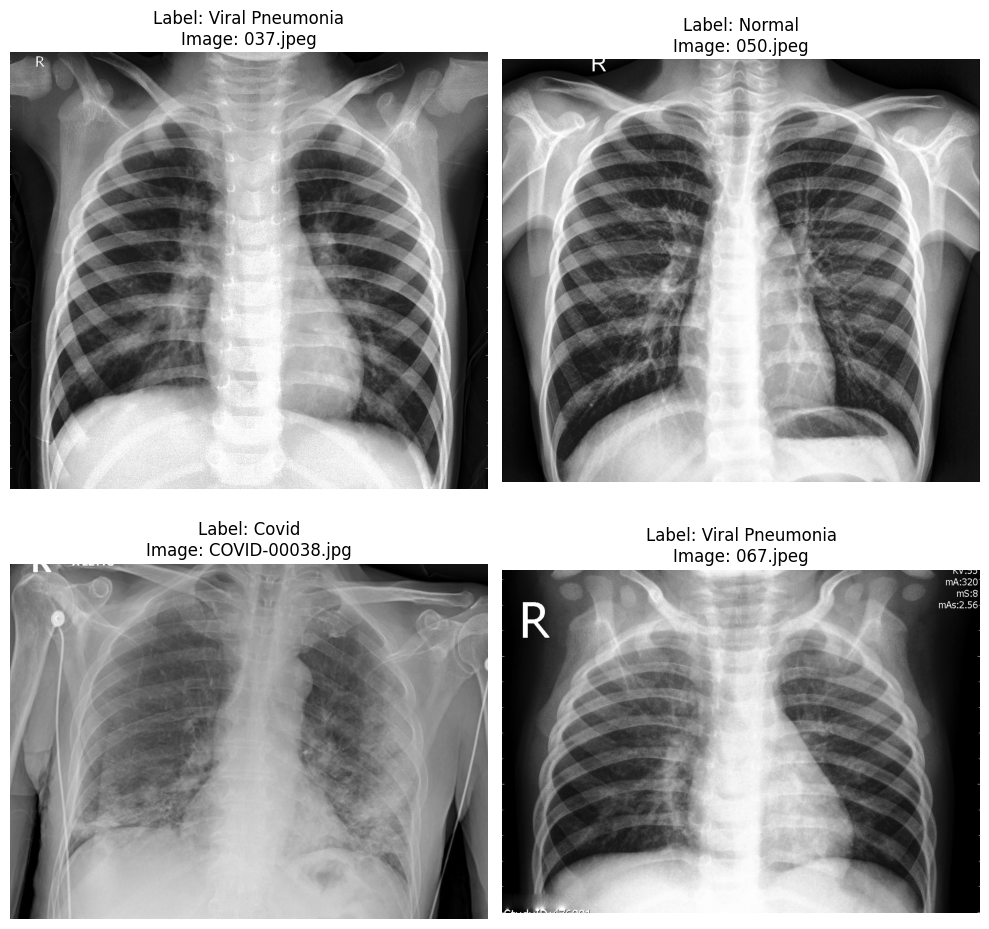

In [5]:
import random
import cv2

def display_random_images_with_labels(image_paths, labels, num_images=4):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Select a random index
        random_index = random.randint(0, len(image_paths) - 1)

        # Get the random image path and label
        random_image_path = image_paths[random_index]
        label = labels[random_index]

        # Load the image
        image = cv2.imread(random_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in a grid with the label
        plt.subplot(2, 2, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}\nImage: {os.path.basename(random_image_path)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display 4 random images with labels
display_random_images_with_labels(image_paths, labels, num_images=4)

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Splitting data into training and validation sets
)

train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the dataset folder
    target_size=(224, 224),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',  # Binary classification (COVID vs Non-COVID)
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
print("Class Indices:", train_generator.class_indices)
print("Training Samples:", train_generator.samples)
print("Validation Samples:", validation_generator.samples)

Class Indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Training Samples: 201
Validation Samples: 50


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,               # Path to the test data
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False            # Do not shuffle test data
)

print("Test Samples:", test_generator.samples)

Found 66 images belonging to 3 classes.
Test Samples: 66


In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='sigmoid')  # Binary classification output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.4341 - loss: 1.8887 - val_accuracy: 0.6200 - val_loss: 0.9010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7753 - loss: 0.7154 - val_accuracy: 0.8000 - val_loss: 0.5001
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8574 - loss: 0.3035 - val_accuracy: 0.9400 - val_loss: 0.1972
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9573 - loss: 0.1287 - val_accuracy: 0.9400 - val_loss: 0.2229
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.9577 - loss: 0.1302 - val_accuracy: 0.8800 - val_loss: 0.4570
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9757 - loss: 0.0790 - val_accuracy: 0.9000 - val_loss: 0.1917
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.9713 - loss: 0.0824 - val_accuracy: 0.9400 - val_loss: 0.2068
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9921 - loss: 0.0425 - val_accuracy: 0.9200 - val_loss: 0.2355
Epoch 9/

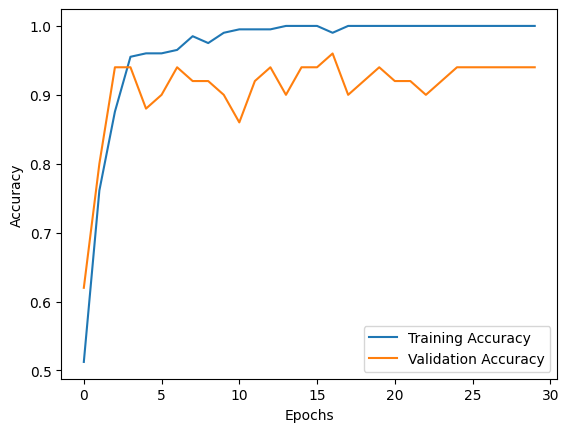

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - accuracy: 0.9387 - loss: 0.3097
Test Accuracy: 0.9242424368858337
